# Proposal Topic Modelling

## Initialize/Imports

In [2]:
# Import libs
import json
import os
import pandas as pd
import re

In [3]:
# Add staff names, place name stopwords to remove from the corpus
staff = ["Andrew Hellman","John Butt","Charlie Petersen","Conrad Ramirez","Doug Johnson","Eric Bodenstab",
         "Mary Boechler","Matt Henderson","Mridhula Manoj","Lindsey Wickman","Luis Acosta","Erik Carlson",
         "Paul Deutsch","Jen Hanley","J. Luke Hodges","Will Kerns","Abdullah Kurkcu","Nikki Olson","Bob Smith",
         "Ron Lowe","Angela Eickelman","Robbert Wieder","Jason Berner","Rebecca Berner","Molly Thiebaut",
         "Joseph El- Hehiawy","Mustafa Al Ogaila","Bill Mischlich","Dave Wieder","Gabe Maliscke","Clint Knutson",
         "Don Nelson","Dominique Lopez","Grant Seger","Chad Stensland","Corey Maynard","Jason Orban","Morgan Wrasper",
         "Nick State","Carter Dahl","Jimmy Coffee","Brad Stangohr","Alex Ranz","AJ Tuck","Brad Niemela",
         "Dustin Kulseth","Marty Jenson","Jon Yocom","Brandon Bucholz","Bennett Pederson","Casey Bekkerus",
         "Chris Greve","Chris Smaaladen","Joe Wade","Justin Johnson","Lyle Zeren","Naga Talluri","Paul Pebler",
         "Reece Skarie","Thomas Reisdorf","Travis Berends","Travis DeJong","Zak Grabowski","Paul Moreau",
         "Steve Windish","Kory Kleinknecht","John Kilpatrick","Daylin Gray","Thomas Fakler","Josh Kueber",
         "Laeken Carey","Clark Roberts","Rachel Heinzen","Melanie Muncy","Tanner Blinsky","Sawyer Kenney",
         "Luke Arnold","Rick Archer","Roger Clay","Brett Lovro","Brian Hiles","Charlie Bechtold","Cassie Borden","Jordon Gall"]

city_county = ['Ulteig','city','county','town','CDOT', 'Adams', 'Arapahoe', 'Arvada', 'Boulder', 'Brighton', 'Broomfield', 'Buena Vista', 'Castle Pines', 
               'Castle Rock', 'Centennial', 'Clear Creek', 'Commerce City', 'Denver', 'Englewood', 'Federal Heights',
              'Fort Morgan', 'Greeley', 'Greenwood Village', 'Jefferson', 'Lafayette', 'Lochbuie', 'Mesa', 'Northglenn', 'Parker',
              'Steamboat', 'Superior', 'Vail', 'Weld', 'Westminster', 'Windsor']

staff = [x.lower() for x in staff]
city_county = [x.lower() for x in city_county]


# Create DataFrame/Text Processing

In [4]:
# Import files, Create DF 
directory = './jsons/'
df = pd.DataFrame(columns=["Filename", "Text"])

# iterate over files in that directory & remove staff members/places 
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    text = ""
    
    # Dump to file
    with open(f, "r") as json_file: 
        data = json.load(json_file)
        
    for key in data:
        x = data[key].lower()
        key = key.lower()
        for member in staff:
            x = x.replace(member.lower(), ' ')
            key = key.replace(member.lower(), ' ')
        for city in city_county:
            x = x.replace(city.lower(), ' ')
            key = key.replace(city.lower(), ' ')
        text = text + " " + key + " " + x
        
    filename = filename.rstrip(".json")
    df = df.append({"Filename":filename, "Text":text}, ignore_index=True)

# Convert the titles to lowercase
df['Text'] = df['Text'].map(lambda x: x.lower())

# Remove punctuation
df['Text'] = df['Text'].map(lambda x: re.sub('[,\.!?&]', '', x))

df.head()

,Filename,Text
0,17.00461 City of Brighton CO_Donelson Park Par...,of donelson park parking lot april 28 201...
1,17.00532 Buena Vista CO_Midland Hills Bridge T...,1 scope of work a approach b crew volunteer ...
2,17.00592 City of Fort Morgan_CentrePointe Plaz...,references relevant experience company profi...
3,17.01422 Adams County CO_ADA Transition Progra...,100% employee-owned office 5575 dtc parkw...
4,17.01998 Greenwood Village_Orchard Road_Dec17_...,a ’s size disciplines has over 70 years o...


In [5]:
import gensim
from gensim.utils import simple_preprocess
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['design', 'project', 'ulteig', 'team', 'projects', 'nd'])    # Note - add or remove misc. stopwords here

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = df.Text.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)
print("some example text data:", data_words[:1][0][:100])

some example text data: ['donelson', 'park', 'parking', 'lot', 'april', 'conducting', 'thorough', 'site', 'visit', 'understands', 'aspects', 'donelson', 'park', 'parking', 'lot', 'including', 'critical', 'issues', 'described', 'non', 'compliant', 'ada', 'ramps', 'part', 'street', 'reconstruction', 'public', 'involvement', 'communication', 'key', 'successfully', 'designing', 'parking', 'lots', 'associated', 'pedestrian', 'facilities', 'east', 'farms', 'neighborhood', 'donelson', 'park', 'communication', 'communication', 'first', 'foremost', 'extending', 'beyond', 'utility', 'companies', 'stakeholders', 'impacted', 'public', 'proposed', 'area', 'surrounded', 'residential', 'homes', 'park', 'working', 'communicating', 'homeowners', 'becomes', 'coordinating', 'access', 'temporary', 'utility', 'disconnects', 'public', 'meeting', 'held', 'options', 'displayed', 'public', 'input', 'revise', 'layouts', 'based', 'public', 'comments', 'provide', 'final', 'option', 'satisfies', 'involved', 'parti

# LDA Topic Modelling

In [6]:
import gensim.corpora as corpora
from gensim.models import LdaMulticore

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Run LDA Topic Modelling
num_topics = 5    # User input: number of topics
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, passes=1)


# Print the Keyword in the topics
from pprint import pprint
pprint(lda_model.print_topics())

[(0,
  '0.010*"construction" + 0.007*"experience" + 0.006*"traffic" + '
  '0.006*"engineering" + 0.006*"transportation" + 0.006*"including" + '
  '0.005*"public" + 0.005*"roadway" + 0.005*"co" + 0.005*"management"'),
 (1,
  '0.012*"construction" + 0.009*"experience" + 0.007*"traffic" + '
  '0.006*"public" + 0.005*"including" + 0.005*"transportation" + 0.005*"work" '
  '+ 0.005*"engineering" + 0.005*"quality" + 0.004*"co"'),
 (2,
  '0.011*"construction" + 0.007*"experience" + 0.007*"traffic" + 0.006*"co" + '
  '0.006*"transportation" + 0.005*"public" + 0.005*"including" + '
  '0.005*"management" + 0.005*"engineering" + 0.004*"services"'),
 (3,
  '0.009*"construction" + 0.007*"public" + 0.007*"co" + 0.006*"traffic" + '
  '0.006*"transportation" + 0.006*"experience" + 0.006*"engineering" + '
  '0.006*"including" + 0.005*"management" + 0.005*"services"'),
 (4,
  '0.009*"construction" + 0.006*"co" + 0.006*"traffic" + '
  '0.006*"transportation" + 0.006*"experience" + 0.005*"public" + '
  '0

### Evaluate LDA topic model

In [7]:
# Coherence Score - for the above LDA model
from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('LDA Coherence Score: ', round(coherence_lda, 4))

LDA Coherence Score:  0.3304


In [8]:
%%time
# Use coherence score to get ideal num. of topics for LDA model
from gensim.models import CoherenceModel
from gensim.models import LdaMulticore

num_topics_list = list(range(1,9))
def find_num_topics(num_topics_list):
    for num_topics in num_topics_list:
        # Build LDA model
        lda_model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, passes=1)

        coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        
        print("Num. Topics: ", num_topics, ', LDA Coherence Score: ', round(coherence_lda, 4), sep="")
    
find_num_topics(num_topics_list)

Num. Topics: 1, LDA Coherence Score: 0.3538
Num. Topics: 2, LDA Coherence Score: 0.3412
Num. Topics: 3, LDA Coherence Score: 0.3276
Num. Topics: 4, LDA Coherence Score: 0.33
Num. Topics: 5, LDA Coherence Score: 0.3404
Num. Topics: 6, LDA Coherence Score: 0.3305
Num. Topics: 7, LDA Coherence Score: 0.334
Num. Topics: 8, LDA Coherence Score: 0.3405
Wall time: 3min 9s


### LDA Visualization

In [12]:
# Uncomment the import below for pyLDAvis versions > 3.2.2
#import pyLDAvis.gensim_models as gm 

# Import for pyLDAvis-version = 3.2.2
import pyLDAvis.gensim as gm 

import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('ldavis_prepared_' + str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gm.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.002919 -0.001261       1        1  38.516444
0      0.000724  0.001906       2        1  27.930463
2      0.000447 -0.000290       3        1  21.033246
3     -0.002528 -0.001944       4        1   6.626718
4     -0.001562  0.001589       5        1   5.893129, topic_info=                Term         Freq        Total Category  logprob  loglift
235     construction  4086.000000  4086.000000  Default  30.0000  30.0000
190               co  1910.000000  1910.000000  Default  29.0000  29.0000
860           public  2127.000000  2127.000000  Default  28.0000  28.0000
1116  transportation  2100.000000  2100.000000  Default  27.0000  27.0000
1110         traffic  2417.000000  2417.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
642          manager    69.429823  1226.516723   Topic5  -5.7596  -0.0402
946             road    67.167120  1263.155091   Topic5  -5.7927  -0.1028
1174           water    68.459653  1344.424556   Topic5  -5.7736  -0.1461
546        including    78.884896  1998.542476   Topic5  -5.6319  -0.4008
838          process    63.068505  1192.050130   Topic5  -5.8556  -0.1078

[475 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
7929      2  0.537165    aadt
3         1  0.388139  access
3         2  0.281006  access
3         3  0.182654  access
3         4  0.075520  access
...     ...       ...     ...
1213      4  0.057908   years
1213      5  0.060164   years
9185      1  0.526885     yes
9185      2  0.210754     yes
9185      3  0.210754     yes

[1315 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4, 5])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


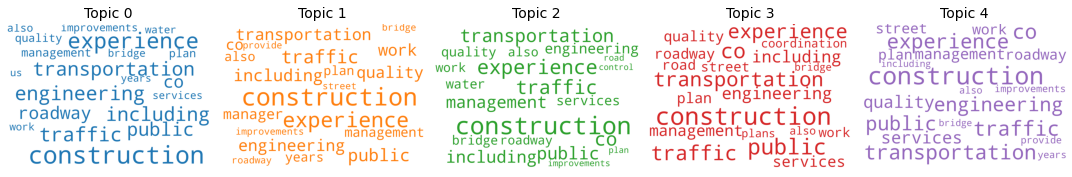

In [13]:
# Wordcloud of LDA, top 10 words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

topics = lda_model.show_topics(num_topics=5, num_words=20, formatted=False)

# Note - change first 2 numbers (row, cols) when changing num. of topics
fig, axes = plt.subplots(1, 5, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud = WordCloud(stopwords=stop_words, background_color='white', width=2500, height=1800, max_words=20, colormap='tab10', \
                      color_func=lambda *args, **kwargs: cols[i], prefer_horizontal=1.0)
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=14))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# NMF - better for texts w similar topics

### Run sklearn NMF package to create Topic Model

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# TF IDF
texts = df['Text']
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=5000)
tfidf = tfidf_vectorizer.fit_transform(texts)
tfidf.toarray()

# NMF - Input: change n_components to desired number of topics
nmf_model = NMF(n_components=5)
nmf_model.fit(tfidf)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


NMF(n_components=5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


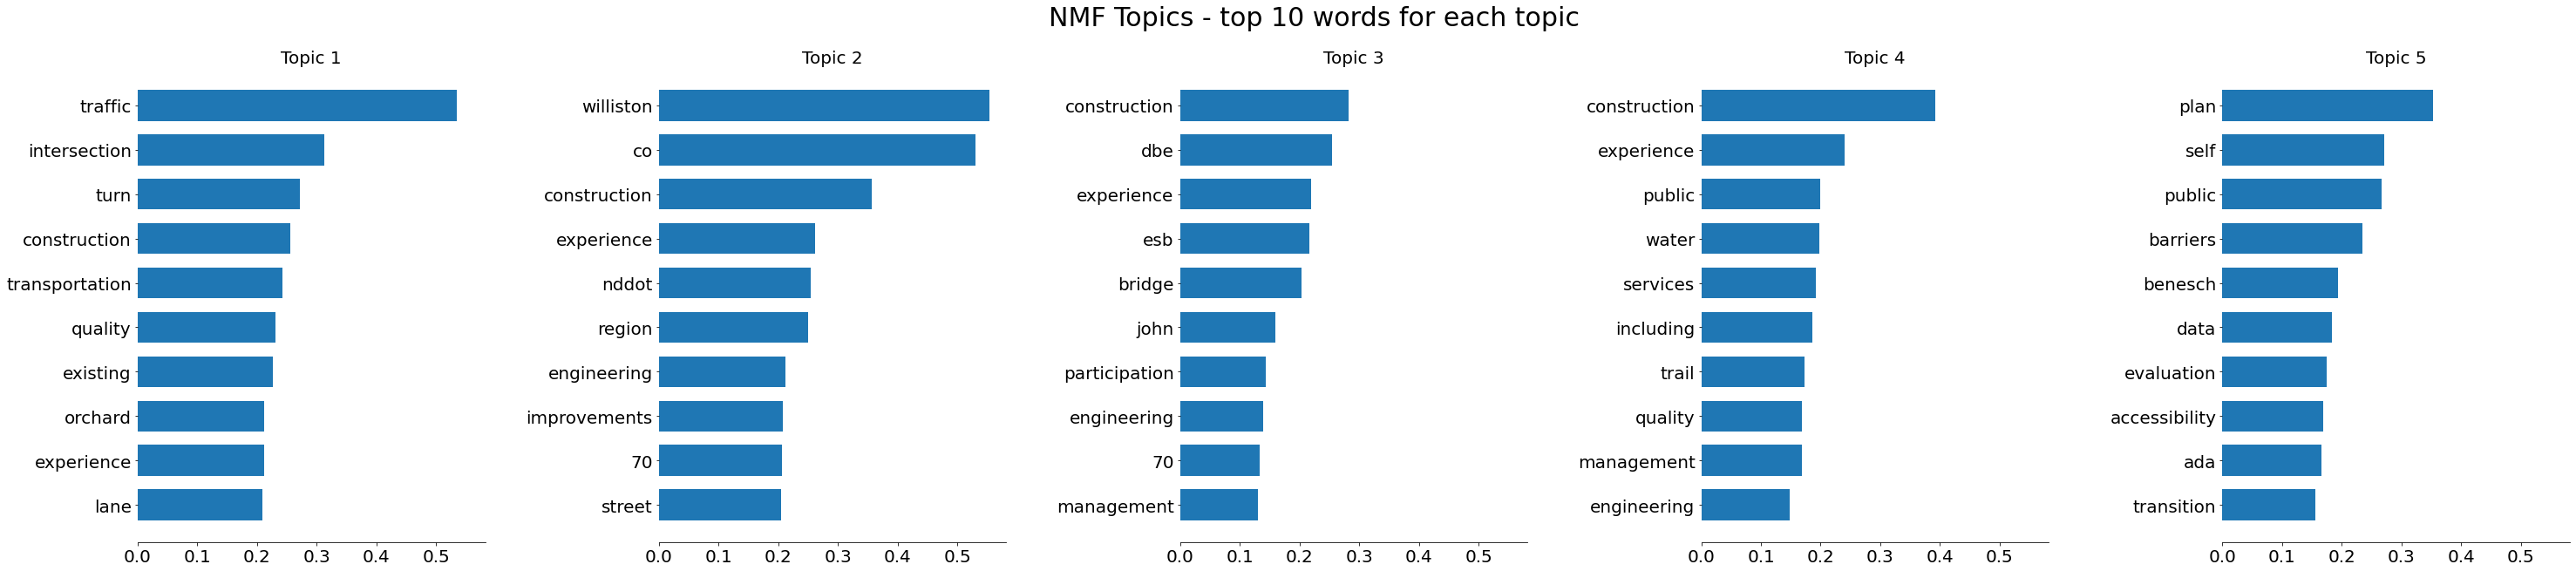

In [17]:
# User inputs: # of words to display, and major title
n_top_words = 10
title = "NMF Topics - top " + str(n_top_words) + " words for each topic"

# plot top 10 words for each topic
feature_names = tfidf_vectorizer.get_feature_names()
fig, axes = plt.subplots(1, 5, figsize=(50, 10), sharex=True)    # Note - change (rows, cols) to match num. topics
axes = axes.flatten()
for topic_idx, topic in enumerate(nmf_model.components_):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]

    ax = axes[topic_idx]
    ax.barh(top_features, weights, height=0.7)
    ax.set_title(f'Topic {topic_idx +1}',
                 fontdict={'fontsize': 20})
    ax.invert_yaxis()
    ax.tick_params(axis='both', which='major', labelsize=20)
    for i in 'top right left'.split():
        ax.spines[i].set_visible(False)
    fig.suptitle(title, fontsize=30)

plt.subplots_adjust(wspace=0.50)
plt.show()

### Use Gensim NMF package to find best # of topics

In [19]:
%%time
# Run NMF with Gensim to find the Coherence Scores & decide num. topics to use
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf


# Getting the data
data = df.Text.values.tolist()
data_words = list(sent_to_words(data))
data_words = remove_stopwords(data_words)
texts = data_words

# Create a dictionary
dictionary = corpora.Dictionary(data_words)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(range(2,10))

# Run the nmf model and calculate the coherence score for each number of topics
coherence_scores = {}
for num in topic_nums:
    
    print("# of Topics:", num, end=", ")

    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_score = round(cm.get_coherence(), 5)
    print("Coherence score:", coherence_score)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# of Topics: 2, Coherence score: 0.33329
# of Topics: 3, Coherence score: 0.33259
# of Topics: 4, Coherence score: 0.33795
# of Topics: 5, Coherence score: 0.34499
# of Topics: 6, Coherence score: 0.33471
# of Topics: 7, Coherence score: 0.34265
# of Topics: 8, Coherence score: 0.33695
# of Topics: 9, Coherence score: 0.34507
Wall time: 1min 56s
